# ETHZ: 227-0966-00L
# Quantitative Big Imaging
# March 15, 2018

## Advanced Segmentation

# Literature / Useful References

- [Markov Random Fields for Image Processing Lecture](https://www.youtube.com/watch?v=vRN_j2j-CC4)
- [Markov Random Fields Chapter](http://www.cise.ufl.edu/~anand/pdf/bookchap.pdf)
- [Fuzzy set theory](http://www.academia.edu/4978200/Applications_of_Fuzzy_Set_Theory_and_Fuzzy_Logic_in_Image_Processing)
- [Superpixels](http://ivrg.epfl.ch/research/superpixels)


***

### Contouring
- [Active Contours / Snakes](http://link.springer.com/article/10.1007%2FBF00133570#page-1)


# Outline

- Motivation
 - Many Samples
 - Difficult Samples
 - Training / Learning
- Thresholding
 - Automated Methods
 - Hysteresis Method

*** 

- Feature Vectors
 - K-Means Clustering
 - Superpixels
 - Probabalistic Models
- Working with Segmented Images
 - Contouring
- Beyond
 - Fuzzy Models
 - Component Labeling

 
# Previously on QBI

- Image acquisition and representations
- Enhancement and noise reduction
- Understanding models and interpreting histograms
- Ground Truth and ROC Curves

*** 

- Choosing a threshold
 - Examining more complicated, multivariate data sets
- Improving segementation with morphological operations
 - Filling holes
 - Connecting objects
 - Removing Noise
- Partial Volume Effect

# Where segmentation fails: Inconsistent Illumination

With inconsistent or every changing illumination it may not be possible to apply the same threshold to every image. 

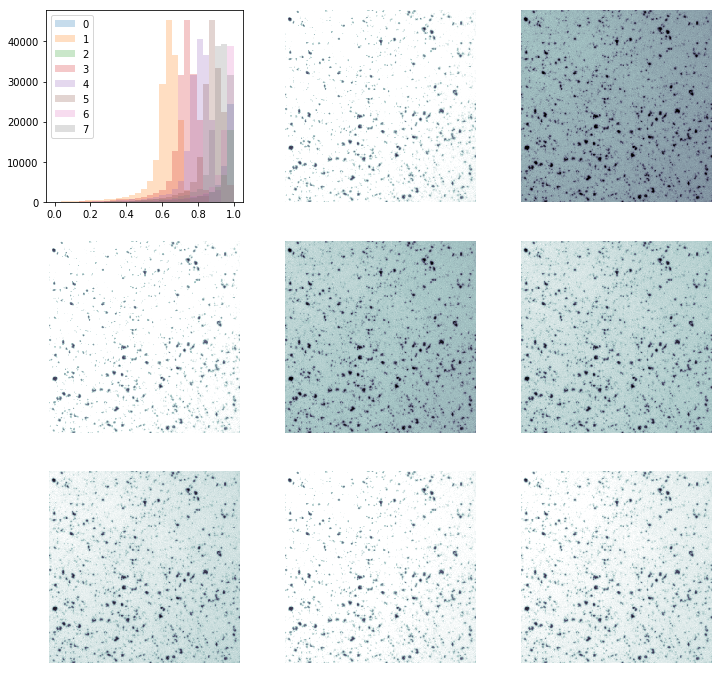

In [1]:
%matplotlib inline
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
cell_img = imread("../common/figures/Cell_Colony.jpg")/255.0
np.random.seed(2018)
m_cell_imgs = [cell_img+k for k in np.random.uniform(-0.25, 0.25, size = 8)]
fig, m_axs = plt.subplots(3, 3, figsize = (12, 12), dpi = 72)
ax1 = m_axs[0,0]
for i, (c_ax, c_img) in enumerate(zip(m_axs.flatten()[1:], m_cell_imgs)):
    ax1.hist(c_img.ravel(), np.linspace(0, 1, 30), label = '{}'.format(i), alpha = 0.25)
    c_ax.imshow(c_img, cmap = 'bone', vmin = 0, vmax = 1)
    c_ax.axis('off')
ax1.legend()

A constant threshold of 0.6 for the different illuminations

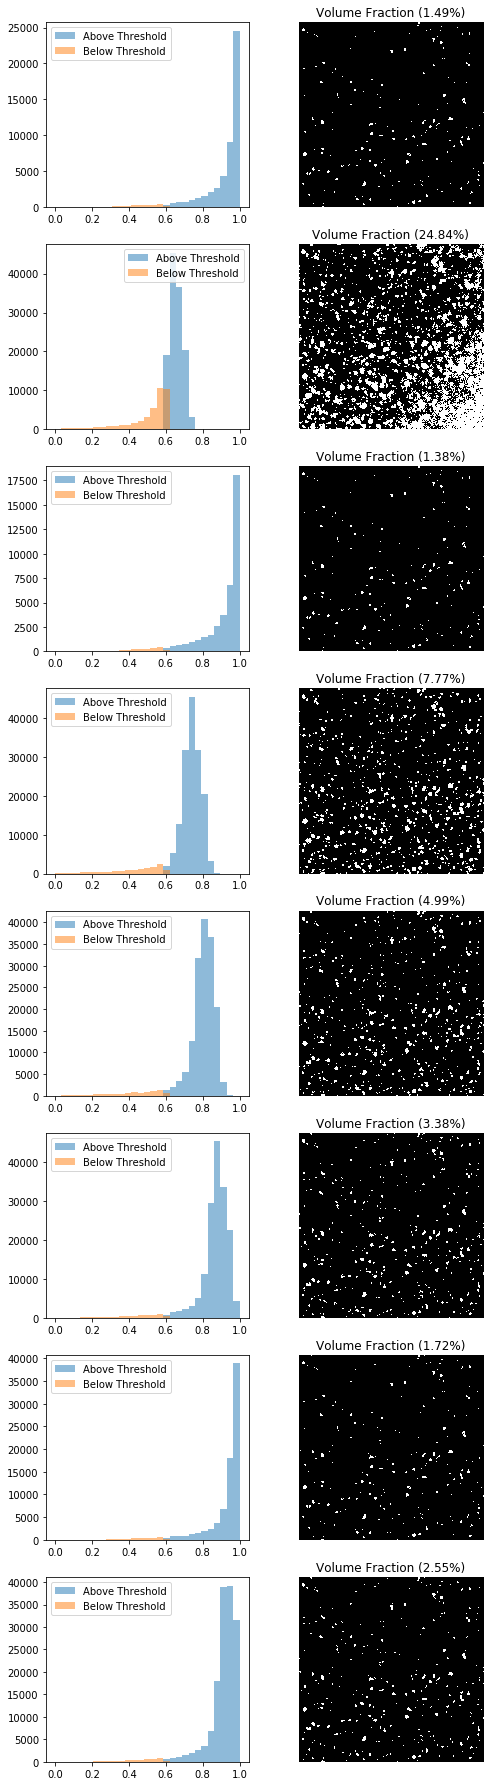

In [2]:
fig, m_axs = plt.subplots(len(m_cell_imgs), 2, 
                          figsize = (4*2, 4*len(m_cell_imgs)), 
                          dpi = 72)
THRESH_VAL = 0.6
for i, ((ax1, ax2), c_img) in enumerate(zip(m_axs, 
                                   m_cell_imgs)):
    ax1.hist(c_img.ravel()[c_img.ravel()>THRESH_VAL], 
             np.linspace(0, 1, 30), 
             label = 'Above Threshold', 
             alpha = 0.5)
    ax1.hist(c_img.ravel()[c_img.ravel()<THRESH_VAL], 
             np.linspace(0, 1, 30), 
             label = 'Below Threshold', 
             alpha = 0.5)
    ax1.legend()
    ax2.imshow(c_img<THRESH_VAL, 
               cmap = 'bone', 
               vmin = 0, vmax = 1)
    ax2.set_title('Volume Fraction (%2.2f%%)' % (100*np.mean(c_img.ravel()<THRESH_VAL)))
    ax2.axis('off')

# Where segmentation fails: Canaliculi

![Bone Slice](ext-figures/bonegfiltslice.png)

### Here is a bone slice

1. Find the larger cellular structures (osteocyte lacunae)
1. Find the small channels which connect them together

***

### The first task 
is easy using a threshold and size criteria (we know how big the cells should be)

### The second 
is much more difficult because the small channels having radii on the same order of the pixel size are obscured by partial volume effects and noise.

# Where segmentation fails: Brain Cortex

![Cortex Image](ext-figures/cortex_mask.png)

- The cortex is barely visible to the human eye
- Tiny structures hint at where cortex is located

*** 

- A simple threshold is insufficient to finding the cortical structures
- Other filtering techniques are unlikely to magicially fix this problem


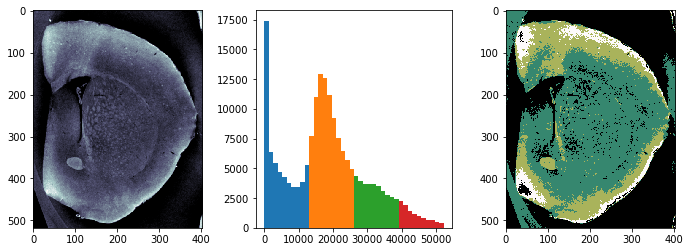

In [3]:
%matplotlib inline
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
cortex_img = imread("ext-figures/cortex.png")
np.random.seed(2018)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, 
                                    figsize = (12, 4), dpi = 72)
ax1.imshow(cortex_img, cmap = 'bone')
thresh_vals = np.linspace(cortex_img.min(), cortex_img.max(), 4+2)[:-1]
out_img = np.zeros_like(cortex_img)
for i, (t_start, t_end) in enumerate(zip(thresh_vals, thresh_vals[1:])):
    thresh_reg = (cortex_img>t_start) & (cortex_img<t_end)
    ax2.hist(cortex_img.ravel()[thresh_reg.ravel()])
    out_img[thresh_reg] = i
ax3.imshow(out_img, cmap = 'gist_earth');

# Automated Threshold Selection

![Many possible automated techniques](ext-figures/automaticthresh.png)

***

Given that applying a threshold is such a common and signficant step, there have been many tools developed to automatically (unsupervised) perform it. A particularly important step in setups where images are rarely consistent such as outdoor imaging which has varying lighting (sun, clouds). The methods are based on several basic principles. 


# Automated Methods


### Histogram-based methods
Just like we visually inspect a histogram an algorithm can examine the histogram and find local minimums between two peaks, maximum / minimum entropy and other factors

- Otsu, Isodata, Intermodes, etc

### Image based Methods
These look at the statistics of the thresheld image themselves (like entropy) to estimate the threshold  


### Results-based Methods
These search for a threshold which delivers the desired results in the final objects. For example if you know you have an image of cells and each cell is between 200-10000 pixels the algorithm runs thresholds until the objects are of the desired size
- More specific requirements need to be implemented manually

# Histogram Methods


Taking a typical image of a bone slice, we can examine the variations in calcification density in the image

***

We can see in the histogram that there are two peaks, one at 0 (no absorption / air) and one at 0.5 (stronger absorption / bone)


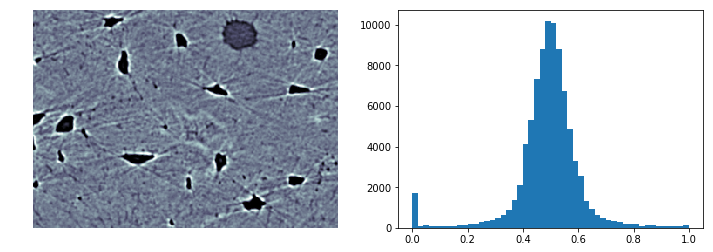

In [4]:
%matplotlib inline
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
bone_img = imread("ext-figures/bonegfiltslice.png")/255.0
np.random.seed(2018)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (12, 4), dpi = 72)
ax1.imshow(bone_img, cmap = 'bone')
ax1.axis('off')
ax2.hist(bone_img.ravel(), 50);

# Histogram Methods

***

### Intermodes
 - Take the point between the two modes (peaks) in the histogram
 
### Otsu

Search and minimize intra-class (within) variance
$$\sigma^2_w(t)=\omega_{bg}(t)\sigma^2_{bg}(t)+\omega_{fg}(t)\sigma^2_{fg}(t)$$

### Isodata

- $\textrm{thresh}= \max(img)+\min(img)/2$
- _while_ the thresh is changing
 - $bg = img<\textrm{thresh}, obj = img>\textrm{thresh}$
 - $\textrm{thresh} = (\textrm{avg}(bg) + \textrm{avg}(obj))/2$

# Try All Thresholds

- [opencv2](https://docs.opencv.org/2.4/doc/tutorials/imgproc/threshold/threshold.html)
- [scikit-image](http://scikit-image.org/docs/dev/auto_examples/xx_applications/plot_thresholding.html)

There are many methods and they can be complicated to implement yourself. Both Fiji and scikit-image offers many of them as built in functions so you can automatically try all of them on your image


skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


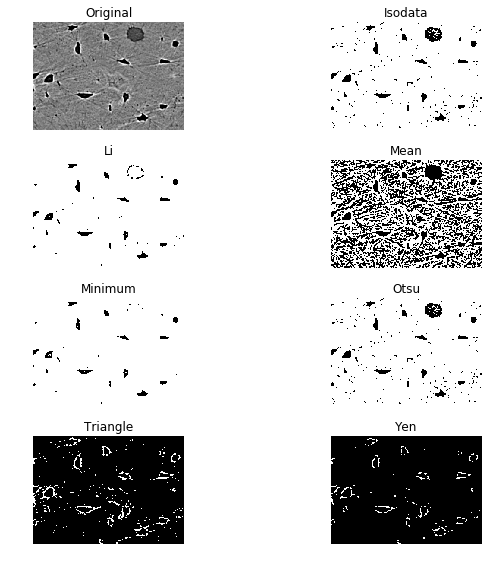

In [5]:
%matplotlib inline
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
bone_img = imread("ext-figures/bonegfiltslice.png")/255.0

from skimage.filters import try_all_threshold

fig, ax = try_all_threshold(bone_img, figsize=(10, 8), verbose=True)

# Pitfalls

While an incredibly useful tool, there are many potential pitfalls to these automated techniques. 

### Histogram-based

These methods are very sensitive to the distribution of pixels in your image and may work really well on images with equal amounts of each phase but work horribly on images which have very high amounts of one phase compared to the others

### Image-based

These methods are sensitive to noise and a large noise content in the image can change statistics like entropy significantly. 

### Results-based

These methods are inherently biased by the expectations you have. If you want to find objects between 200 and 1000 pixels you will, they just might not be anything meaningful.

# Realistic Approaches for Dealing with these Shortcomings


Imaging science rarely represents the ideal world and will never be 100% perfect. At some point we need to write our master's thesis, defend, or publish a paper. These are approaches for more qualitative assessment we will later cover how to do this a bit more robustly with quantitative approaches

### Model-based

One approach is to try and simulate everything (including noise) as well as possible and to apply these techniques to many realizations of the same image and qualitatively keep track of how many of the results accurately identify your phase or not. Hint: >95% seems to convince most biologists

### Sample-based

Apply the methods to each sample and keep track of which threshold was used for each one. Go back and apply each threshold to each sample in the image and keep track of how many of them are correct enough to be used for further study.

### Worst-case Scenario

Come up with the worst-case scenario (noise, misalignment, etc) and assess how inacceptable the results are. Then try to estimate the quartiles range (75% - 25% of images).

# Hysteresis Thresholding

For some images a single threshold does not work
- large structures are very clearly defined
- smaller structures are difficult to differentiated (see [partial volume effect](http://bit.ly/1mW7kdP))

[ImageJ Source](http://imagejdocu.tudor.lu/doku.php?id=plugin:segmentation:hysteresis_thresholding:start)

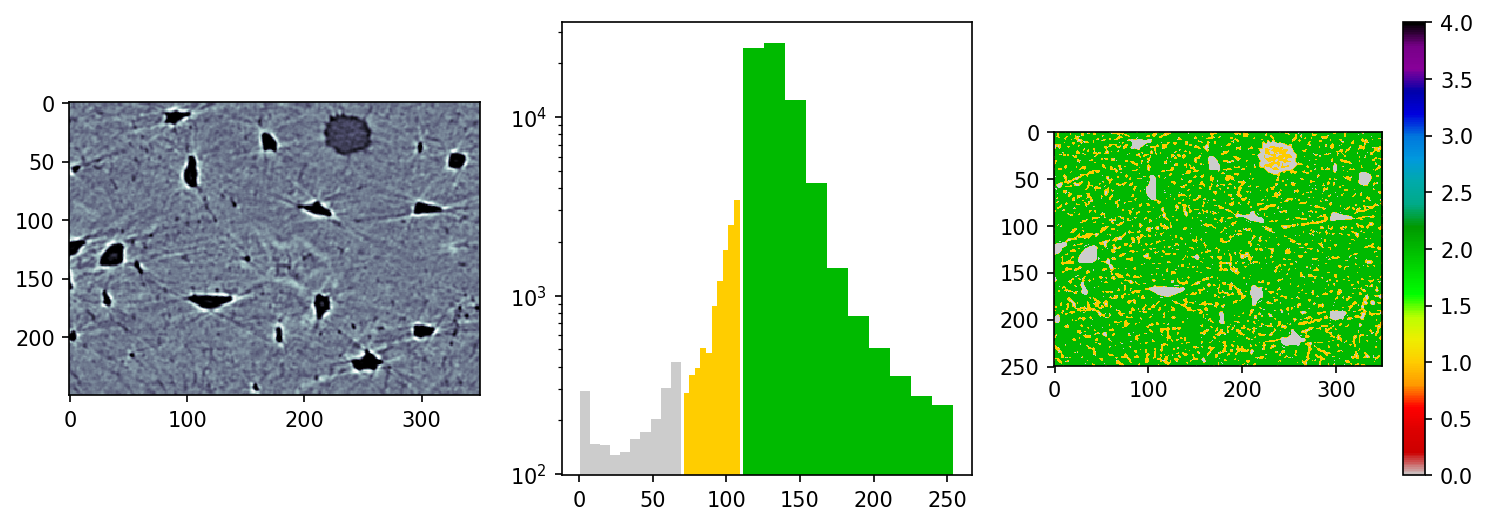

In [6]:
%matplotlib inline
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
bone_img = imread("ext-figures/bonegfiltslice.png")
np.random.seed(2018)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, 
                                    figsize = (12, 4), dpi = 150)
cmap = plt.cm.nipy_spectral_r
ax1.imshow(bone_img, cmap = 'bone')
thresh_vals = [0, 70, 110, 255]
out_img = np.zeros_like(bone_img)
for i, (t_start, t_end) in enumerate(zip(thresh_vals, thresh_vals[1:])):
    thresh_reg = (bone_img>t_start) & (bone_img<t_end)
    ax2.hist(bone_img.ravel()[thresh_reg.ravel()], 
             color = cmap(i/(len(thresh_vals))))
    out_img[thresh_reg] = i
ax2.set_yscale("log", nonposy='clip')
th_ax = ax3.imshow(out_img, 
                   cmap = cmap, 
                   vmin = 0, 
                   vmax = len(thresh_vals))
plt.colorbar(th_ax)

# Goldilocks Situation
Here we end up with a goldilocks situation (Mama bear and Papa Bear), one is too low and the other is too high

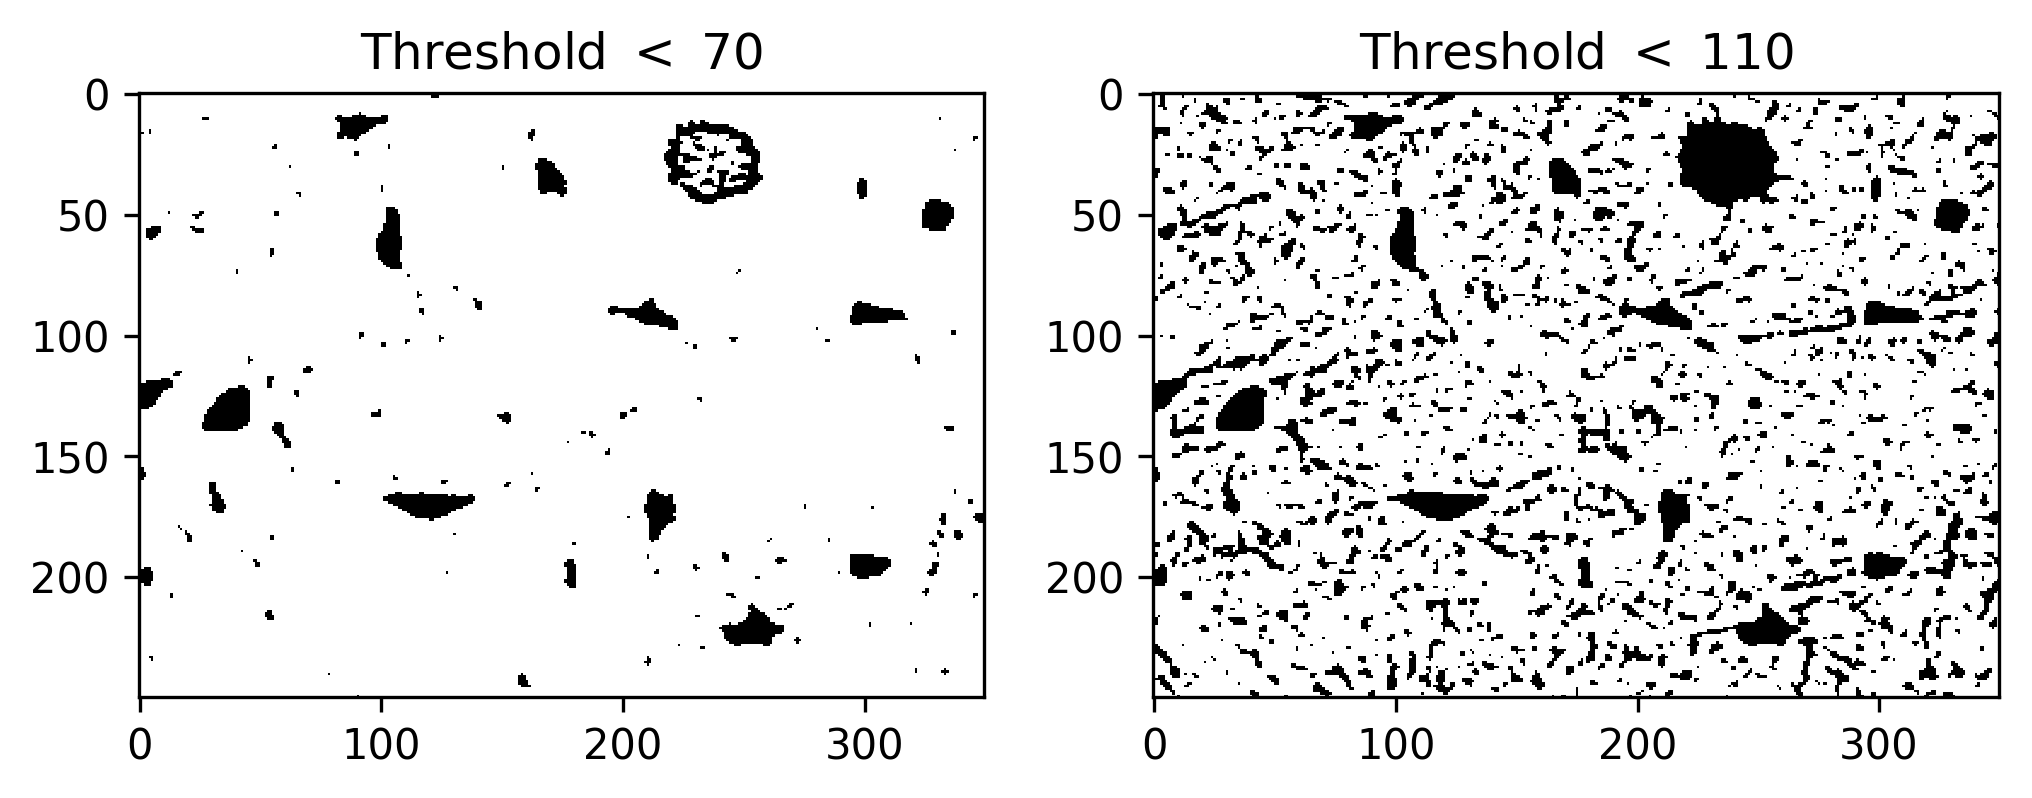

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8, 4), dpi = 300)
ax1.imshow(bone_img<thresh_vals[1], cmap = 'bone_r')
ax1.set_title('Threshold $<$ %d' % (thresh_vals[1]))
ax2.imshow(bone_img<thresh_vals[2], cmap = 'bone_r')
ax2.set_title('Threshold $<$ %d' % (thresh_vals[2]));

# Baby Bear
We can thus follow a process for ending up with a happy medium of the two  

## Hysteresis Thresholding: Reducing Pixels

Now we apply the following steps. 

1. Take the first threshold image with the highest (more strict) threshold
1. Remove the objects which are not cells (too small) using an opening operation.
1. Take a second threshold image with the higher value
1. Combine both threshold images
1. Keep the _between_ pixels which are connected (by looking again at a neighborhood $\mathcal{N}$) to the _air_ voxels and ignore the other ones. This goes back to our original supposition that the smaller structures are connected to the larger structures


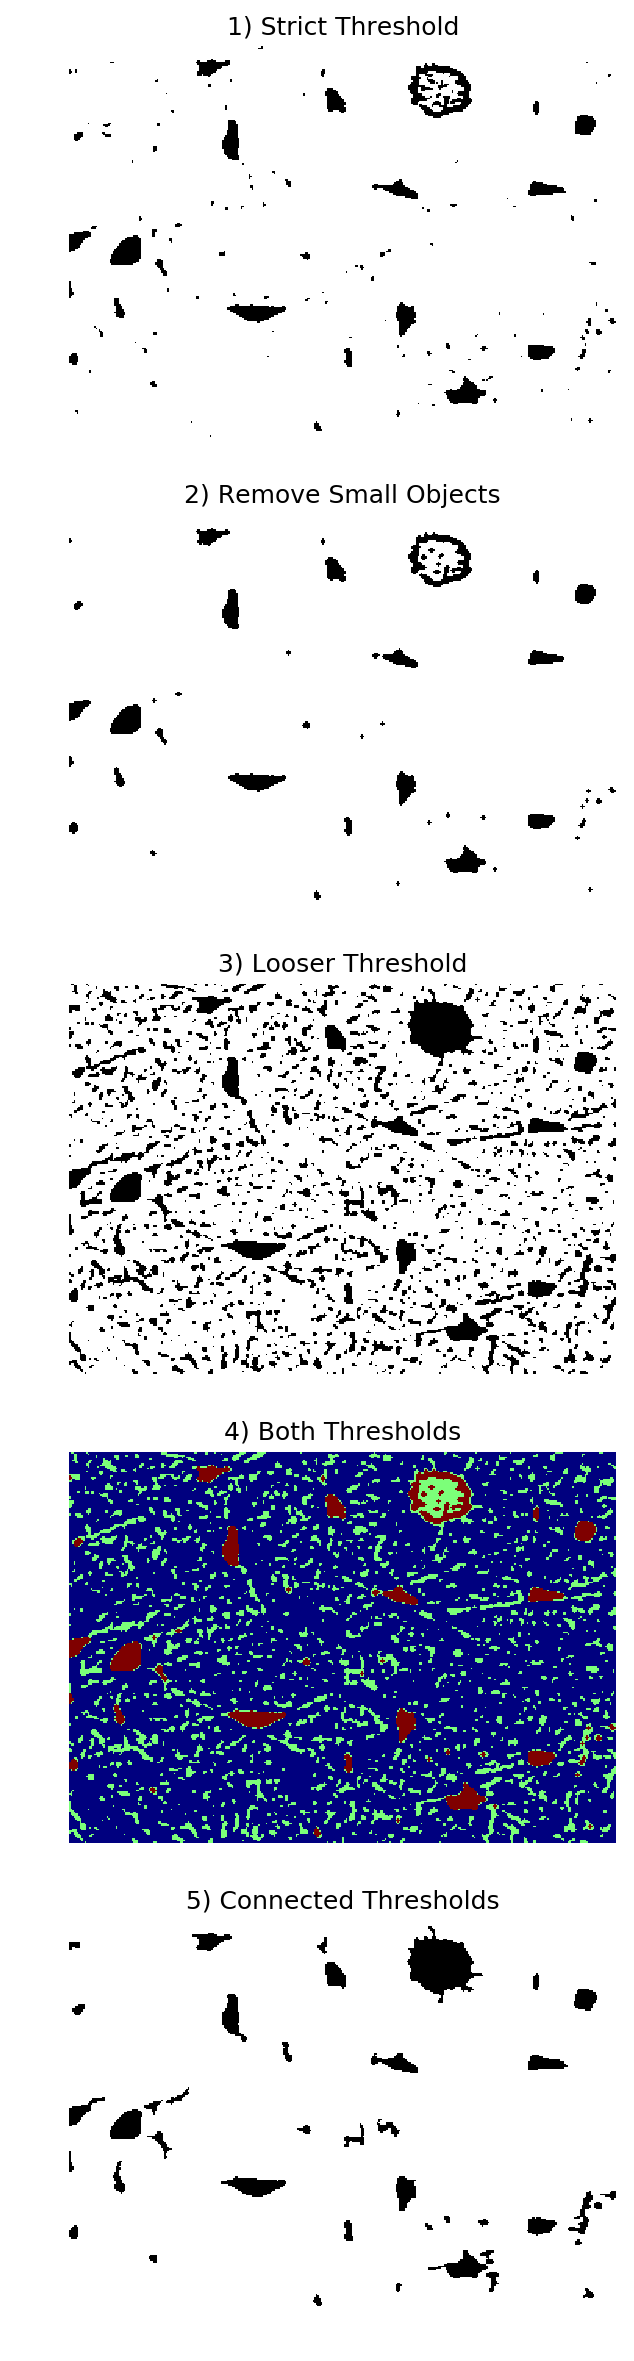

In [8]:
%matplotlib inline
from skimage.morphology import dilation, opening, disk
from collections import OrderedDict
step_list = OrderedDict()
step_list['Strict Threshold'] = bone_img<thresh_vals[1]
step_list['Remove Small Objects'] = opening(step_list['Strict Threshold'], disk(1))
step_list['Looser Threshold'] = bone_img<thresh_vals[2]
step_list['Both Thresholds'] = 1.0*step_list['Looser Threshold'] + 1.0*step_list['Remove Small Objects']
# the tricky part keeping the between images
step_list['Connected Thresholds'] = step_list['Remove Small Objects']
for i in range(10):
    step_list['Connected Thresholds'] = dilation(step_list['Connected Thresholds'] , disk(1.8)) & step_list['Looser Threshold']


fig, ax_steps = plt.subplots(len(step_list), 1,
                             figsize = (6, 4*(len(step_list))), 
                             dpi = 150)

for i, (c_ax, (c_title, c_img)) in enumerate(zip(ax_steps.flatten(), step_list.items()),1):
    c_ax.imshow(c_img, cmap = 'bone_r' if c_img.max()<=1 else 'jet')
    c_ax.set_title('%d) %s' % (i, c_title))
    c_ax.axis('off')